In [1]:
import sys, os, copy, re
import dill as pickle # this serializes all the functions inside the quantification dict
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [4]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

In [5]:
### Read quantification function ###
dict_pickle_fnam = 'AA-quant_april_22.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_quant = pickle.load(handle)

### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('H1299-GOT-DKO_Asp-titration.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'].values / metab_dict_mes[k]['ISTD Response'].values
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fnam.split('_')[-1] for fnam in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)


### Impute concentration and add to metabolite dataframe ###
for metab in metab_names_mes[:]:
    # Assign imputed concentration:
    if metab in piece_wise_fit_quant:
        conc_list = list()
        estimator_list = list()
        for rr in metab_dict_mes[metab]['Response Ratio'].values:
            conc, estimator = impute_conc(piece_wise_fit_quant[metab], rr)
            conc_list.append(conc)
            estimator_list.append(estimator)
        metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
        metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list

In [6]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    try:
        nam_conc = nam.split()[0]
        df[nam_conc] = metab_dict_mes[nam]['imputed_sample_conc'] / metab_dict_mes[nam]['dilution']
    except:
        df[nam] = metab_dict_mes[nam]['Response']

df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

df_mean = df.groupby(['Aspartate_media', 'Treatment']).mean(numeric_only=True).reset_index()
df_stdev = df.groupby(['Aspartate_media', 'Treatment']).std(numeric_only=True).reset_index()
df_stdev['Prlfr'] = df_mean['Prlfr_stdev']

In [7]:
df_mean

,Aspartate_media,Treatment,Sample ID,Replicate,Prlfr,Prlfr_stdev,Cell_vol,Cell_vol_stdev,dilution,Adenine pos,...,Threonine,Tryptophan,Tyrosine,UDP neg,UMP neg,Uridine neg,Valine,NAD-NADH,IMP-AMP,GSH-GSSG
0,2,Sal. mix,0.0,2.0,0.421641,0.023300,6469.000000,308.730735,0.023802,7.140692e+08,...,3895.649911,177.545663,790.537472,1.408117e+07,3.589061,0.170516,1209.210251,47.263568,0.007179,1.443863e-06
1,3,Sal. mix,0.0,2.0,0.517031,0.009565,5853.000000,212.533919,0.023802,4.829004e+08,...,4034.105559,166.598566,737.612286,1.215870e+07,3.368067,0.126696,1129.701436,49.754293,0.019451,2.221952e-06
2,4,Sal. mix,0.0,2.0,0.549239,0.032320,6905.666667,235.997646,0.023802,4.572726e+08,...,5456.869489,233.779008,1061.723566,1.010215e+07,3.318097,0.065638,1740.991062,50.589012,0.015873,6.072733e-07
3,6,Sal. mix,0.0,2.0,0.580416,0.076987,6527.333333,208.219969,0.023802,2.694367e+08,...,3178.442057,123.402653,600.251199,4.415352e+06,0.940122,0.032282,966.523662,43.512359,0.152989,5.695358e-07
4,10,Sal. mix,0.0,2.0,0.677912,0.041993,6266.666667,266.653750,0.023802,3.297523e+08,...,4783.048087,163.756434,793.669153,5.895282e+06,0.814374,0.039652,1217.869112,76.387639,0.097661,1.834957e-06
5,10,Vehicle,0.0,2.0,0.222803,0.006466,13337.666667,1327.500492,0.023802,5.076240e+07,...,3961.454106,133.806227,618.826711,2.337336e+06,0.616884,0.020189,940.707549,90.978476,0.409677,8.951607e-07
6,15,Sal. mix,0.0,2.0,0.731165,0.041482,6670.000000,233.136584,0.023802,1.733512e+08,...,6640.191724,208.852470,1062.881238,9.363485e+06,1.727820,0.055484,1661.570981,65.599956,0.021606,3.427287e-06
7,15,Vehicle,0.0,2.0,0.374970,0.019628,8713.666667,313.029640,0.023802,1.022674e+08,...,5929.380393,198.354576,954.501147,3.553637e+06,0.696605,0.041076,1346.567250,93.925316,0.294374,3.772925e-06
8,20,Sal. mix,0.0,2.0,0.756372,0.011226,6403.333333,137.415024,0.023802,1.385545e+08,...,7253.185183,201.679434,1080.373584,9.150661e+06,1.753055,0.095835,1634.953689,54.754419,0.021768,4.492973e-06
9,20,Vehicle,0.0,2.0,0.488810,0.048340,8596.333333,479.395684,0.023802,5.447329e+07,...,6195.540455,189.261847,954.847391,3.773144e+06,0.899703,0.019306,1438.787063,99.226810,0.835058,1.366062e-06


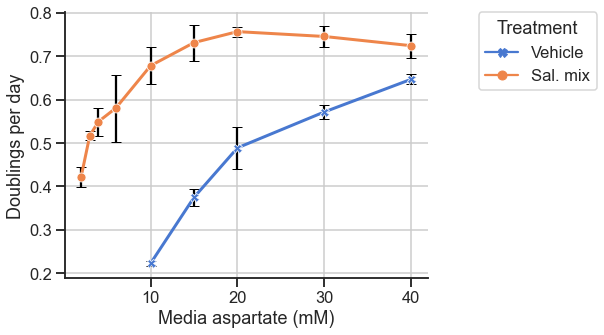

In [8]:
### Proliferation as a function of media Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean, x='Aspartate_media', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean['Prlfr'].values, x=df_mean['Aspartate_media'].values, yerr=df_mean['Prlfr_stdev'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Media aspartate (mM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Prlfr-media-Aspartate.pdf', bbox_inches='tight')

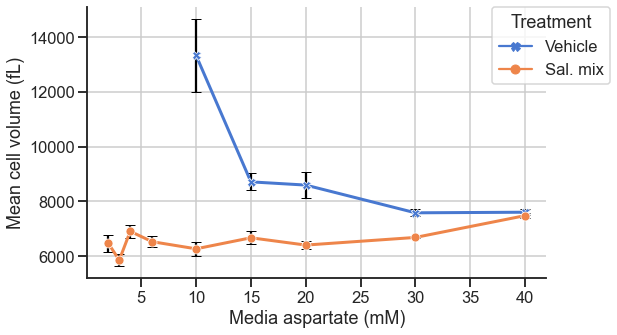

In [9]:
### Cell volume as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean, x='Aspartate_media', y='Cell_vol', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean['Cell_vol'].values, x=df_mean['Aspartate_media'].values, yerr=df_mean['Cell_vol_stdev'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Media aspartate (mM)')
g1.set_ylabel('Mean cell volume (fL)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Cell-vol-media-Aspartate.pdf', bbox_inches='tight')

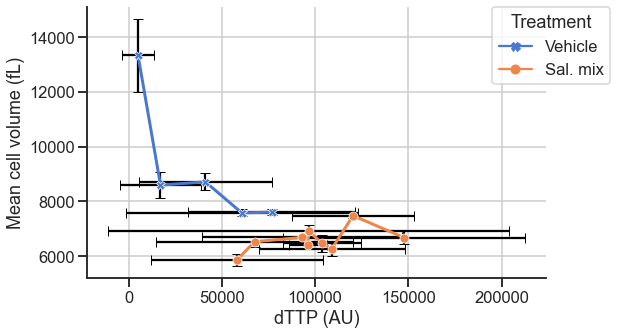

In [10]:
### Cell volume as a function of dTTP ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean, x='dTTP neg', y='Cell_vol', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean['Cell_vol'].values, x=df_mean['dTTP neg'].values, yerr=df_mean['Cell_vol_stdev'].values, xerr=df_stdev['dTTP neg'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('dTTP (AU)')
g1.set_ylabel('Mean cell volume (fL)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Cell-vol-dTTP.pdf', bbox_inches='tight')

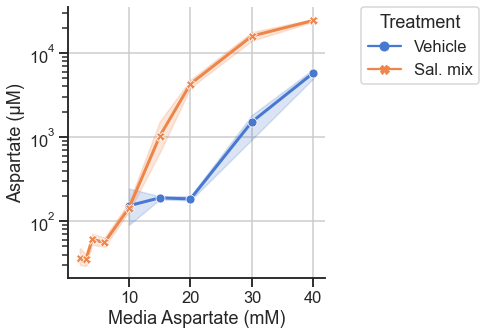

In [11]:
### Intracellular aspartate as a function of media asp ###

fig, ax1 = plt.subplots(1, 1, figsize=(7.4, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df[mask], x='Aspartate_media', y='Aspartate', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.set(yscale="log")

g1.set_xlabel('Media Aspartate (mM)')
g1.set_ylabel('Aspartate (μM)')
#g1.set(ylim=(230, 1300))

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Metformin-Aspartate.pdf', bbox_inches='tight')

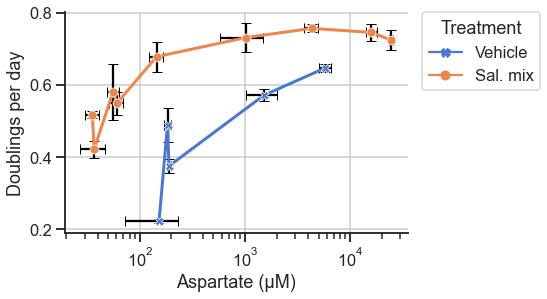

In [12]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['Aspartate'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['Aspartate'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Prlfr.pdf', bbox_inches='tight')

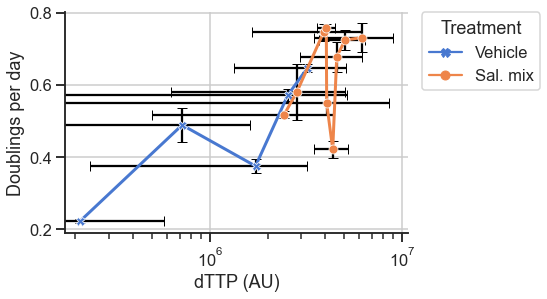

In [43]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='dTTP neg', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['dTTP neg'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['dTTP neg'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('dTTP (AU)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/dTTP-Prlfr.pdf', bbox_inches='tight')

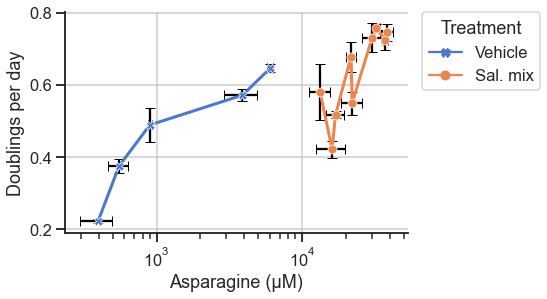

In [20]:
### Proliferation as a function of Asparagine ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Asparagine', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['Asparagine'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['Asparagine'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Asparagine (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Prlfr.pdf', bbox_inches='tight')

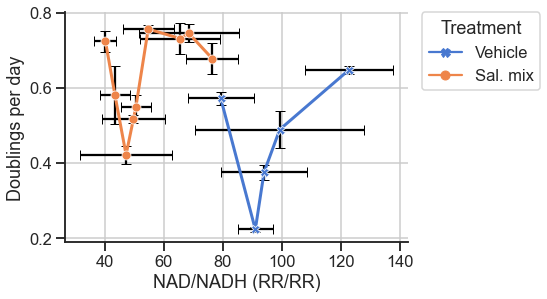

In [21]:
### Proliferation as a function of NAD/NADH ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='NAD-NADH', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['NAD-NADH'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=1)


g1.set_xlabel('NAD/NADH (RR/RR)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/NAD-NADH-Prlfr.pdf', bbox_inches='tight')

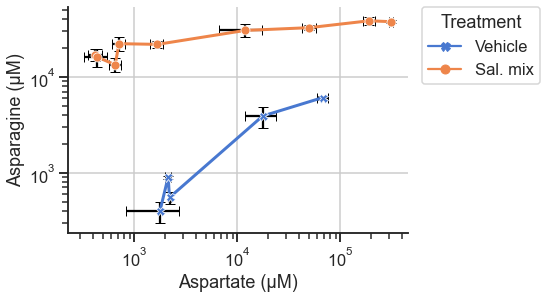

In [22]:
### Asparagine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate', y='Asparagine', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Asparagine'].values, x=df_mean[mask]['Aspartate'].values, yerr=df_stdev[mask]['Asparagine'].values, xerr=df_stdev[mask]['Aspartate'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")
g1.set(yscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Asparagine (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Asparagine.pdf', bbox_inches='tight')

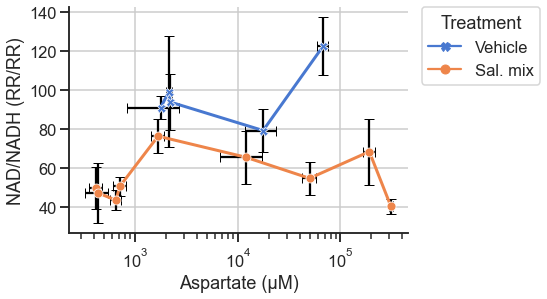

In [23]:
### NAD/NADH as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate', y='NAD-NADH', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['NAD-NADH'].values, x=df_mean[mask]['Aspartate'].values, yerr=df_stdev[mask]['NAD-NADH'].values, xerr=df_stdev[mask]['Aspartate'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('NAD/NADH (RR/RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-NAD-NADH.pdf', bbox_inches='tight')

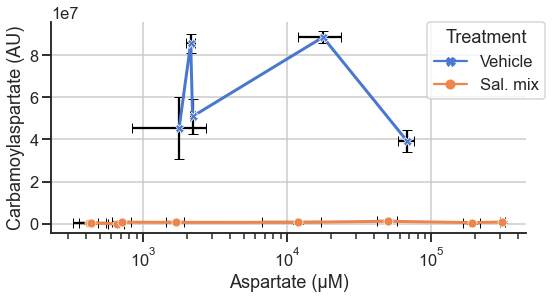

In [24]:
### Carbamoylaspartate as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate', y='Carbamoylaspartate neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Carbamoylaspartate neg'].values, x=df_mean[mask]['Aspartate'].values, yerr=df_stdev[mask]['Carbamoylaspartate neg'].values, xerr=df_stdev[mask]['Aspartate'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Carbamoylaspartate (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Carbamoylaspartate.pdf', bbox_inches='tight')

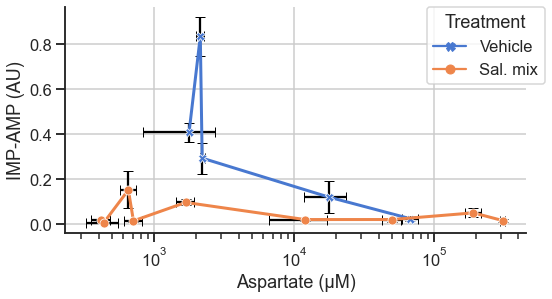

In [25]:
### IMP-AMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate', y='IMP-AMP', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['IMP-AMP'].values, x=df_mean[mask]['Aspartate'].values, yerr=df_stdev[mask]['IMP-AMP'].values, xerr=df_stdev[mask]['Aspartate'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('IMP-AMP (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-IMP-AMP.pdf', bbox_inches='tight')

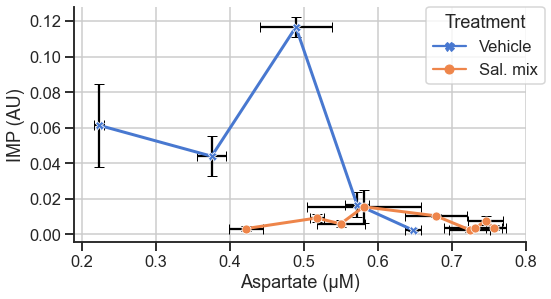

In [13]:
### IMP-AMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Prlfr', y='IMP pos', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['IMP pos'].values, x=df_mean[mask]['Prlfr'].values, yerr=df_stdev[mask]['IMP pos'].values, xerr=df_stdev[mask]['Prlfr'].values, fmt='none', color='black', capsize=5, zorder=1)

#g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('IMP (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-IMP-AMP.pdf', bbox_inches='tight')

In [26]:
metab_names_mes

['Adenine pos',
 'Adenosine pos',
 'ADP pos',
 'Alanine pos',
 'AMP pos',
 'Arginine pos',
 'Argininosuccinate neg',
 'Asparagine pos',
 'Aspartate neg',
 'ATP pos',
 'Carbamoylaspartate neg',
 'Cis-aconitate neg',
 'Dihydroorotate neg',
 'dTTP neg',
 'Fumarate neg',
 'Glutamate neg',
 'Glutamine pos',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'Glycine neg',
 'GMP pos',
 'IMP pos',
 'Isoleucine pos',
 'Lactate neg',
 'Leucine pos',
 'Lysine pos',
 'Malate neg',
 'NAD pos',
 'NADH pos',
 'Ornithine pos',
 'Phenylalanine pos',
 'Proline pos',
 'Serine neg',
 'Succinate neg',
 'Taurine pos',
 'Threonine neg',
 'Tryptophan pos',
 'Tyrosine pos',
 'UDP neg',
 'UMP neg',
 'Uridine neg',
 'Valine pos']